In [36]:
import pandas as pd
import requests
from io import StringIO
import os
from dotenv import load_dotenv
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import date



In [37]:
load_dotenv()

True

# Lectura y Preparación

In [38]:

#
# myurl = os.environ["DETALLE_TAREAS_FULL_URL"] + "?" + os.environ["AZURE_DATALAKE_GENAI_TOKEN"]
#df = pd.read_parquet(myurl)
df = pd.read_parquet("data\\DETALLE_TAREAS_COMPLETO.parquet")
df


,FECHA_CIERRE,CODIGO_TAREA,DESCRIPCION_TAREA,INICIO,FIN,DURACION_SEGUNDOS,DURACION
0,2024-07-24,PX999C17,Depuracion del FSC017,2024-07-25 03:36:06,2024-07-25 03:36:08,2.0,00:00:02
1,2024-11-05,PX999C17,Depuracion del FSC017,2024-11-06 05:14:46,2024-11-06 05:14:47,1.0,00:00:01
2,2024-11-06,PX999C17,Depuracion del FSC017,2024-11-07 03:26:57,2024-11-07 03:26:58,1.0,00:00:01
3,2024-11-07,PX999C17,Depuracion del FSC017,2024-11-08 03:11:20,2024-11-08 03:11:21,1.0,00:00:01
4,2024-11-08,PX999C17,Depuracion del FSC017,2024-11-09 02:30:38,2024-11-09 02:30:39,1.0,00:00:01
...,...,...,...,...,...,...,...
12505,2024-11-15,PCSMI001B,Rendicion Batch,2024-11-16 02:36:57,2024-11-16 02:36:58,1.0,00:00:01
12506,2024-11-16,PCSMI001B,Rendicion Batch,2024-11-17 01:40:20,2024-11-17 01:40:21,1.0,00:00:01
12507,2024-11-18,PCSMI001B,Rendicion Batch,2024-11-19 03:02:57,2024-11-19 03:02:58,1.0,00:00:01
12508,2024-11-19,PCSMI001B,Rendicion Batch,2024-11-20 02:25:59,2024-11-20 02:26:00,1.0,00:00:01


In [39]:
df["FECHA_CIERRE"]=pd.to_datetime(df.FECHA_CIERRE,yearfirst=True,dayfirst=True)
df["DIA_SEMANA"]=df.FECHA_CIERRE.dt.day_of_week+1
df["DIA_SEMANA_NOM"]=df.FECHA_CIERRE.dt.day_name()
df["DIA_MES"]=df.FECHA_CIERRE.dt.days_in_month
df


,FECHA_CIERRE,CODIGO_TAREA,DESCRIPCION_TAREA,INICIO,FIN,DURACION_SEGUNDOS,DURACION,DIA_SEMANA,DIA_SEMANA_NOM,DIA_MES
0,2024-07-24,PX999C17,Depuracion del FSC017,2024-07-25 03:36:06,2024-07-25 03:36:08,2.0,00:00:02,3,Wednesday,31
1,2024-11-05,PX999C17,Depuracion del FSC017,2024-11-06 05:14:46,2024-11-06 05:14:47,1.0,00:00:01,2,Tuesday,30
2,2024-11-06,PX999C17,Depuracion del FSC017,2024-11-07 03:26:57,2024-11-07 03:26:58,1.0,00:00:01,3,Wednesday,30
3,2024-11-07,PX999C17,Depuracion del FSC017,2024-11-08 03:11:20,2024-11-08 03:11:21,1.0,00:00:01,4,Thursday,30
4,2024-11-08,PX999C17,Depuracion del FSC017,2024-11-09 02:30:38,2024-11-09 02:30:39,1.0,00:00:01,5,Friday,30
...,...,...,...,...,...,...,...,...,...,...
12505,2024-11-15,PCSMI001B,Rendicion Batch,2024-11-16 02:36:57,2024-11-16 02:36:58,1.0,00:00:01,5,Friday,30
12506,2024-11-16,PCSMI001B,Rendicion Batch,2024-11-17 01:40:20,2024-11-17 01:40:21,1.0,00:00:01,6,Saturday,30
12507,2024-11-18,PCSMI001B,Rendicion Batch,2024-11-19 03:02:57,2024-11-19 03:02:58,1.0,00:00:01,1,Monday,30
12508,2024-11-19,PCSMI001B,Rendicion Batch,2024-11-20 02:25:59,2024-11-20 02:26:00,1.0,00:00:01,2,Tuesday,30


In [58]:
post_festivos=[
    date(2024,8,8)
    ,date(2024,8,20)
    ,date(2024,10,15)
    ,date(2024,11,5)
    ,date(2024,11,12)    
    ]

df["POST_FESTIVO"]=df.FECHA_CIERRE.isin(post_festivos)


C:\Users\juanmedina\AppData\Local\Temp\ipykernel_11736\1663451165.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["POST_FESTIVO"]=df.FECHA_CIERRE.isin(post_festivos)


In [41]:
df["ID_TAREA"]=df.CODIGO_TAREA+"-"+df.DESCRIPCION_TAREA
df["DURACION_MIN"]=(df.DURACION_SEGUNDOS/60).round(0)
df["DURACION_HR"]=df.DURACION_SEGUNDOS/60/60
df["PAUSA"]=df.CODIGO_TAREA=="PAUSA"

In [42]:
df["PAUSA"].value_counts()


PAUSA
False    12012
True       498
Name: count, dtype: int64

# Análisis

## Duración total

### Distribución

In [43]:
df.groupby(["FECHA_CIERRE"], as_index=False,)["DURACION_MIN"].agg(["max","min","mean","median","sum"]	).sort_values("sum",ascending=False)

,FECHA_CIERRE,max,min,mean,median,sum
6,2024-07-31,111.0,0.0,4.762500,1.0,762.0
2,2024-07-26,203.0,0.0,5.503817,0.0,721.0
11,2024-08-06,180.0,0.0,4.559055,0.0,579.0
62,2024-10-07,106.0,0.0,4.285714,0.0,540.0
85,2024-11-05,110.0,0.0,4.095238,0.0,516.0
...,...,...,...,...,...,...
81,2024-10-30,39.0,0.0,2.484127,0.0,313.0
55,2024-09-28,37.0,0.0,2.440945,0.0,310.0
89,2024-11-09,29.0,0.0,2.373016,0.0,299.0
93,2024-11-15,31.0,0.0,2.365079,0.0,298.0


array([[<Axes: title={'center': 'sum'}>]], dtype=object)

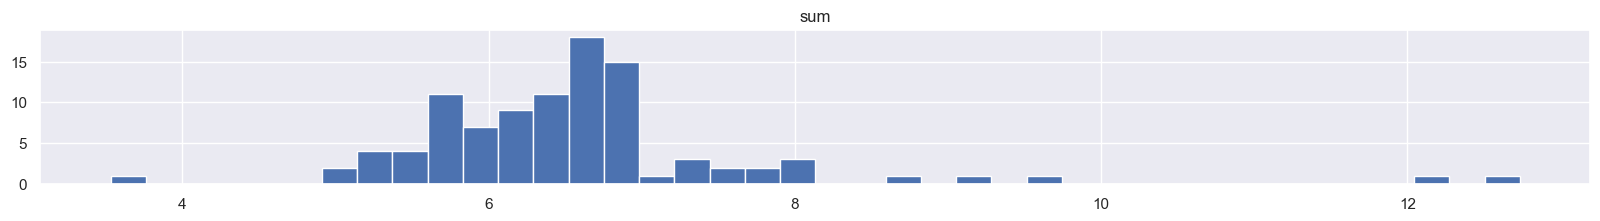

In [44]:
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).hist(bins=40)

<Axes: >

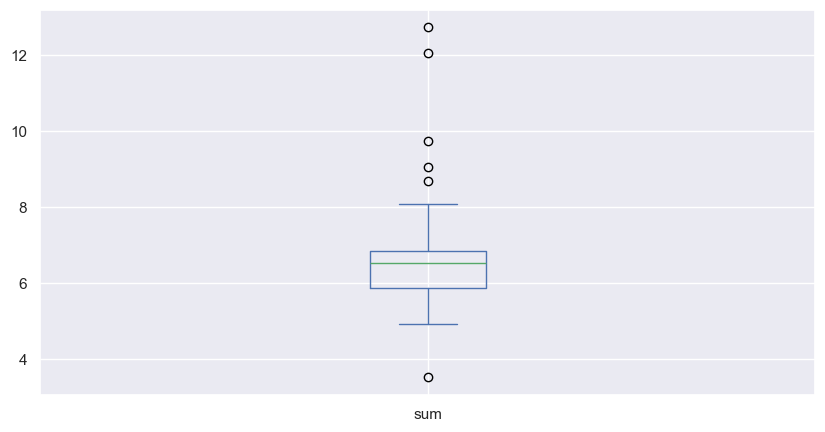

In [45]:
sns.set_theme(rc={'figure.figsize':(10,5)})
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

<Axes: xlabel='FECHA_CIERRE'>

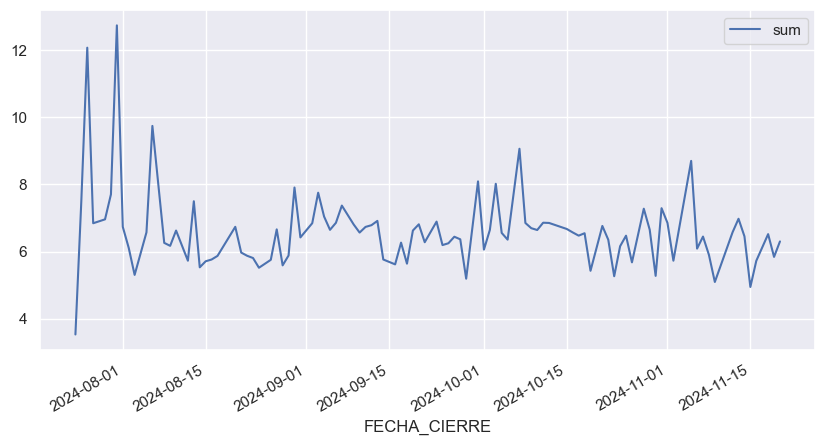

In [46]:
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot()

Conclusion. Distribución de cola derecha con valores extremos (anomalias) por encima de 500

<Axes: >

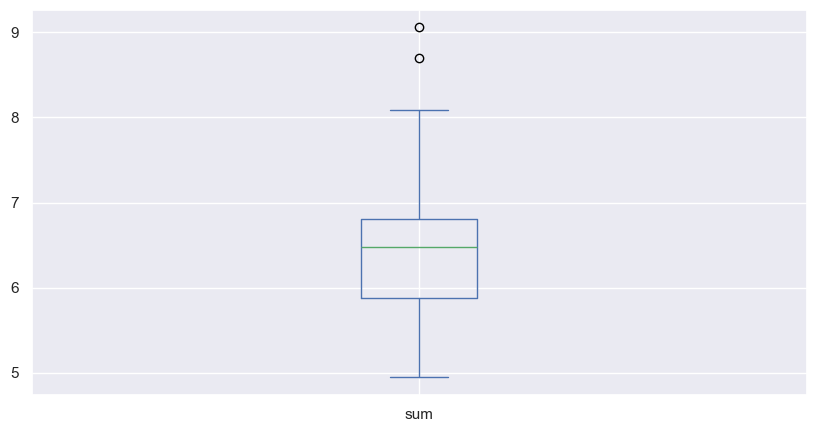

In [47]:

df_parcial=df.query("FECHA_CIERRE >= '2024-08-15'")
df_parcial.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

# Pausas

In [48]:
df_sum=df_parcial.groupby("FECHA_CIERRE", as_index=True)["DURACION_MIN"].agg(["max","sum"])
df_sum.rename(columns={"max":"TAREA_MAX","sum":"TOTAL"}, inplace=True)
df_sum_pausas=df_parcial[df_parcial.PAUSA].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_sum_pausas.set_index("FECHA_CIERRE", inplace=True)
df_sum_pausas.rename(columns={"DURACION_MIN":"DURACION_PAUSAS"},inplace=True)
df_sum=df_sum.join(df_sum_pausas,)
df_sum["SIN_PAUSA"]=df_sum.TOTAL - df_sum.DURACION_PAUSAS


<Axes: xlabel='FECHA_CIERRE'>

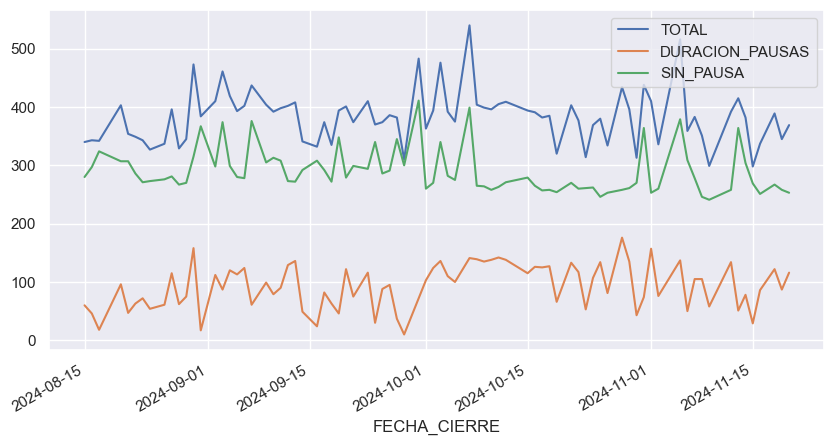

In [49]:
df_sum[['TOTAL','DURACION_PAUSAS','SIN_PAUSA']].plot(subplots=False)

Los datos antes del mes 9 tienen picos y n estaban asociados a pausas

<Axes: xlabel='FECHA_CIERRE'>

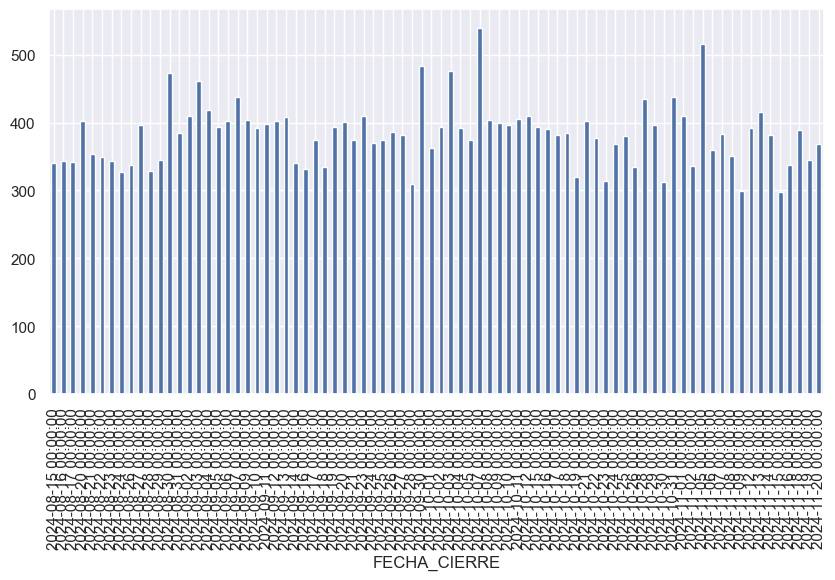

In [50]:
df_sum.query("index >= '2024-08-15' ")["TOTAL"].plot.bar()


<Axes: xlabel='FECHA_CIERRE'>

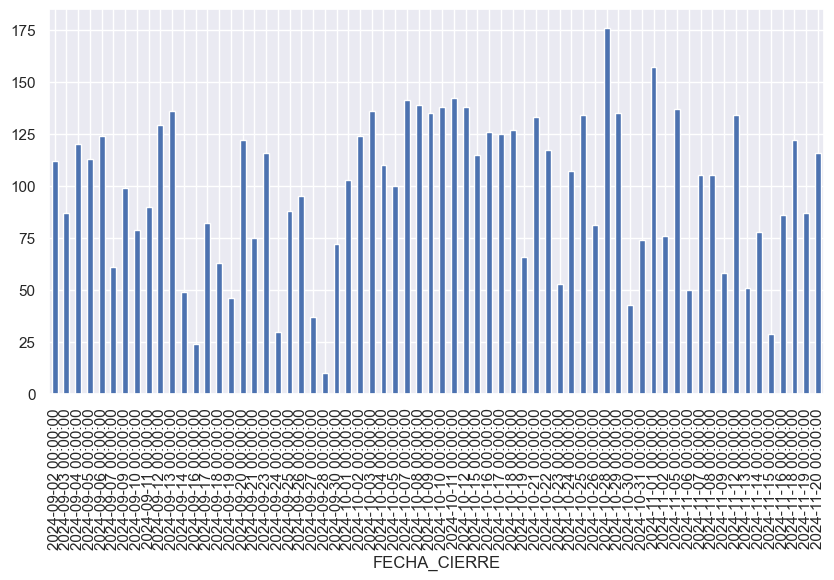

In [51]:
df_sum_parcial=df_sum.query("index >= '2024-09-01' ")
df_sum_parcial["DURACION_PAUSAS"].plot.bar()


<Axes: >

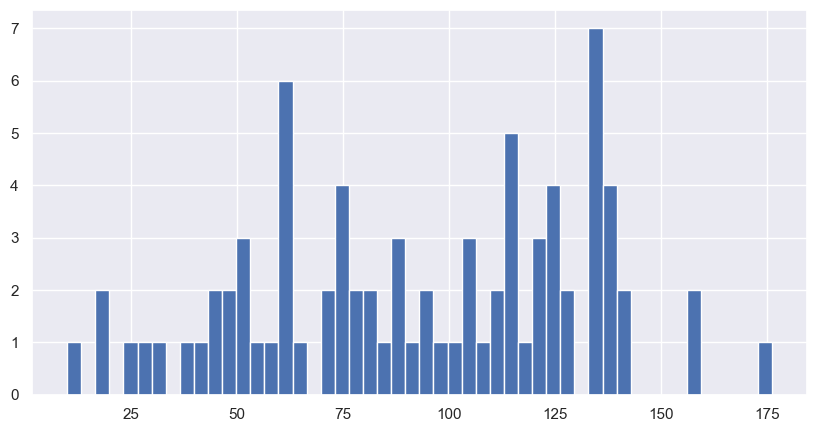

In [52]:
df_sum["DURACION_PAUSAS"].hist(bins=50)

array([<Axes: xlabel='FECHA'>, <Axes: xlabel='FECHA'>,
       <Axes: xlabel='FECHA'>], dtype=object)

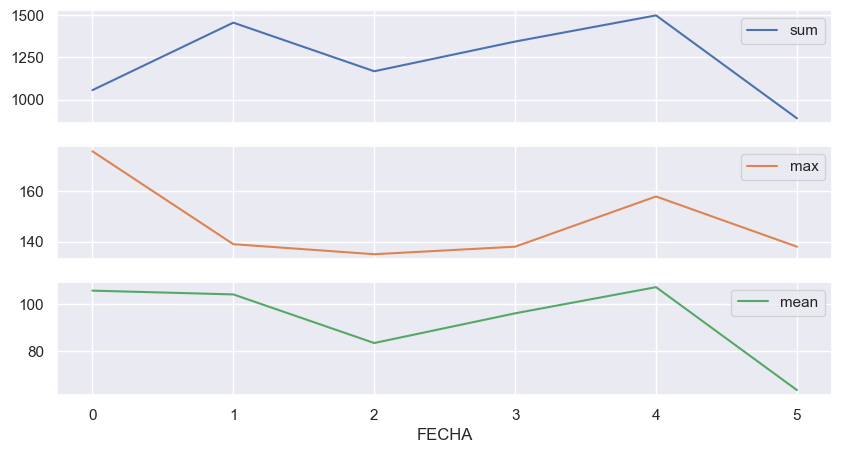

In [55]:
sns.set_theme(rc={'figure.figsize':(10,5)})
df_sum["FECHA"]=df_sum.index
df_sum.groupby(df_sum["FECHA"].dt.day_of_week)["DURACION_PAUSAS"].agg(["sum","max","mean"]).plot(subplots=True)

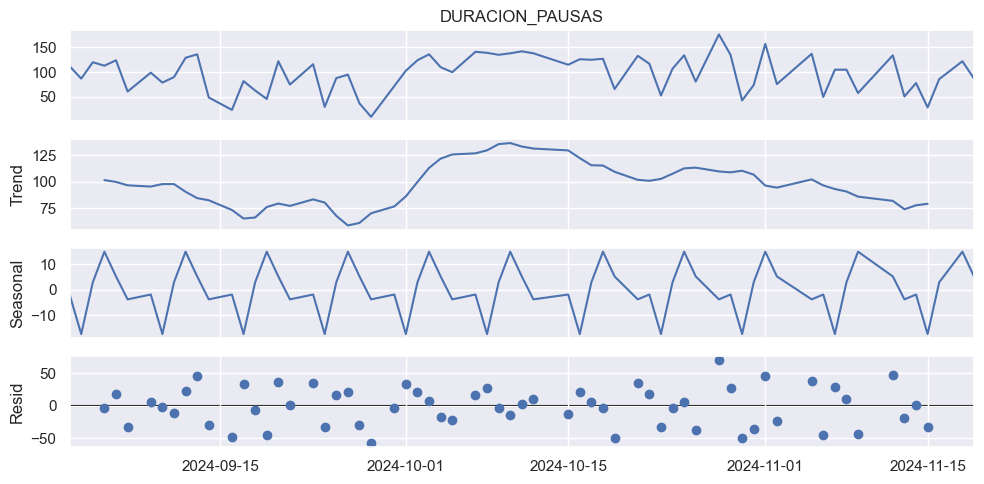

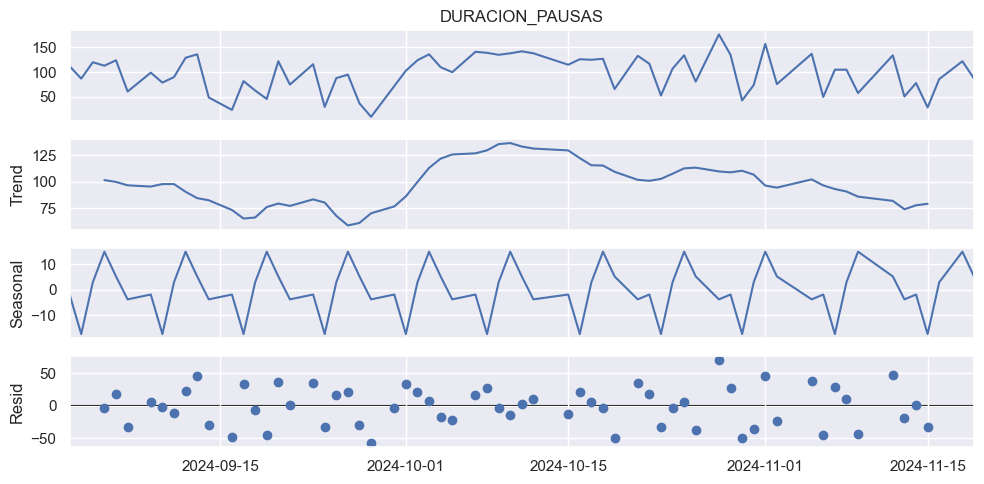

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(df_sum_parcial["DURACION_PAUSAS"], model="additive", period=6)

decompose_result_mult.plot()

In [60]:
df_sum["POST_FESTIVO"]=df_sum.FECHA.isin(post_festivos)

C:\Users\juanmedina\AppData\Local\Temp\ipykernel_11736\3203688096.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_sum["POST_FESTIVO"]=df_sum.FECHA.isin(post_festivos)


In [61]:
df_sum[df_sum["POST_FESTIVO"]]

,TAREA_MAX,TOTAL,DURACION_PAUSAS,SIN_PAUSA,FECHA,POST_FESTIVO
FECHA_CIERRE,,,,,,
2024-08-20,86.0,403.0,96.0,307.0,2024-08-20,True
2024-10-15,96.0,394.0,115.0,279.0,2024-10-15,True
2024-11-05,110.0,516.0,137.0,379.0,2024-11-05,True
2024-11-12,95.0,392.0,134.0,258.0,2024-11-12,True


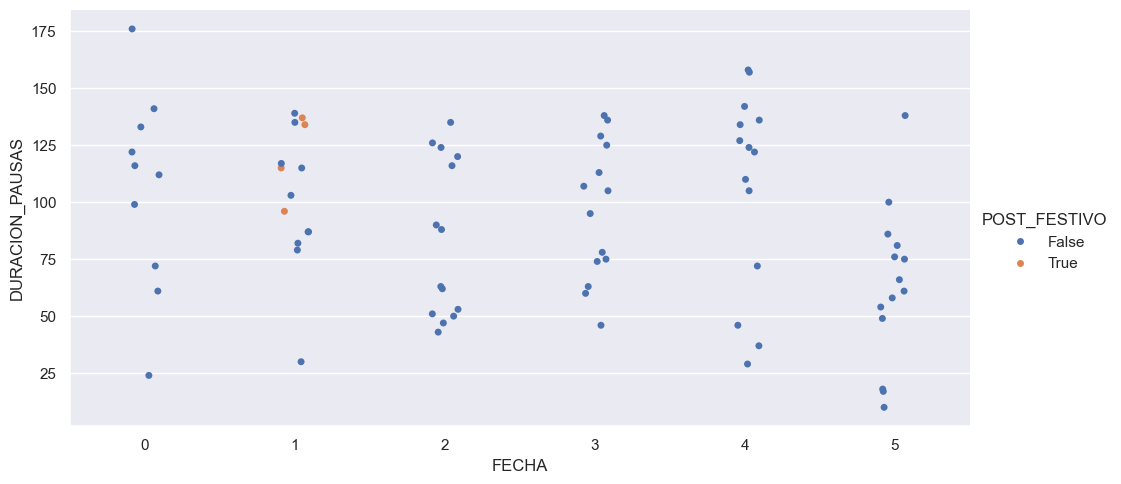

In [90]:
# df_sum_parcial.groupby(df_sum_parcial["FECHA"].dt.day_of_week)["SIN_PAUSA"].agg(["sum","max","mean", ]).plot(subplots=True)
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["DURACION_PAUSAS"], hue=df_sum.POST_FESTIVO,  aspect=2)

## Sin pausas

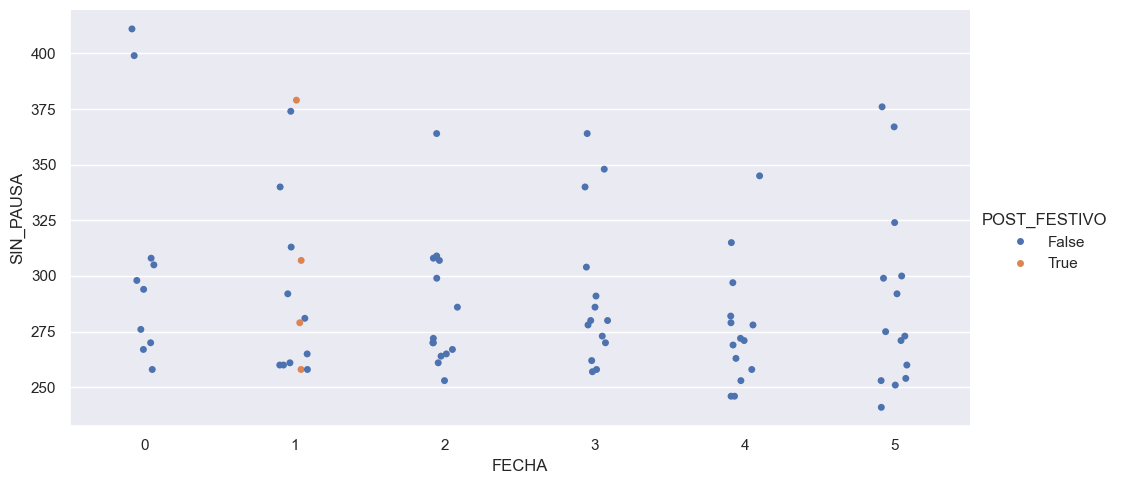

In [89]:
sns.set_theme(rc={'figure.figsize':(8,3)})
# df_sum_parcial.groupby(df_sum_parcial["FECHA"].dt.day_of_week)["SIN_PAUSA"].agg(["sum","max","mean", ]).plot(subplots=True)
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["SIN_PAUSA"], hue=df_sum.POST_FESTIVO,  aspect=2)

In [ ]:
sns.set_theme(rc={'figure.figsize':(20,10)})
decompose_result_mult = seasonal_decompose(df_sum_parcial["SIN_PAUSA"], model="additive", period=6)

decompose_result_mult.plot();

NameError: name 'seasonal_decompose' is not defined

# Tareas representativas

### Top tareas minutos totales

In [65]:
df_parcial = df.query("FECHA_CIERRE >= '2024-08-15'")
df_tareas_agg=df_parcial.groupby(["CODIGO_TAREA"], as_index=True,)["DURACION_MIN"].agg(["max","min","mean","median","count","sum"]	).sort_values("sum",ascending=False)


In [66]:
df_agg_top=df_tareas_agg.sort_values("sum",ascending=False).head(10)
df_agg_top



,max,min,mean,median,count,sum
CODIGO_TAREA,,,,,,
PAUSA,129.0,0.0,18.301235,4.0,405,7412.0
PBCGD017,42.0,27.0,34.475000,36.0,80,2758.0
PSNG9122,21.0,17.0,18.712500,19.0,80,1497.0
PJBWM077,22.0,14.0,17.737500,18.0,80,1419.0
PP017,30.0,12.0,16.937500,17.0,80,1355.0
PNU00217,32.0,7.0,16.787500,16.0,80,1343.0
PNU00002,22.0,10.0,15.787500,17.0,80,1263.0
PCC00003,26.0,11.0,14.237500,14.0,80,1139.0
PPP92005,45.0,9.0,13.750000,13.0,80,1100.0


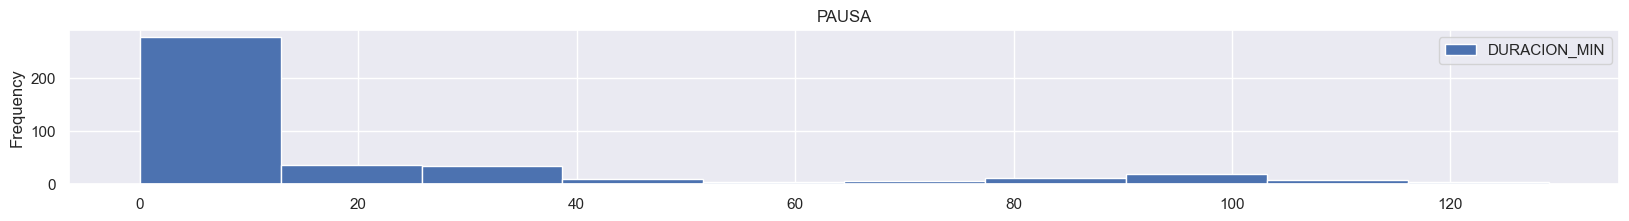

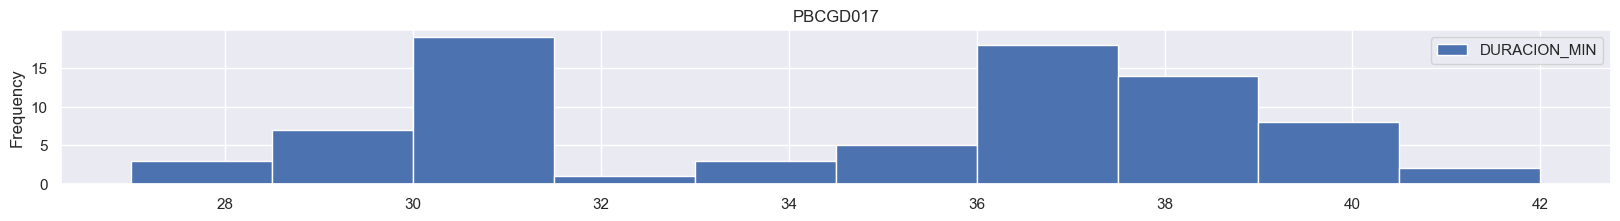

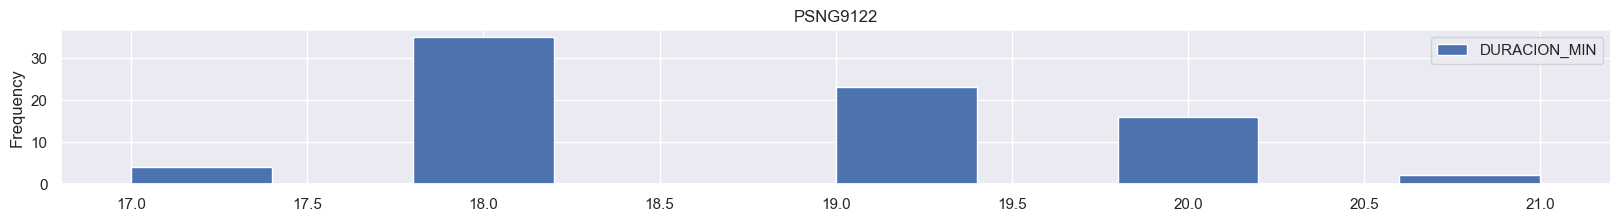

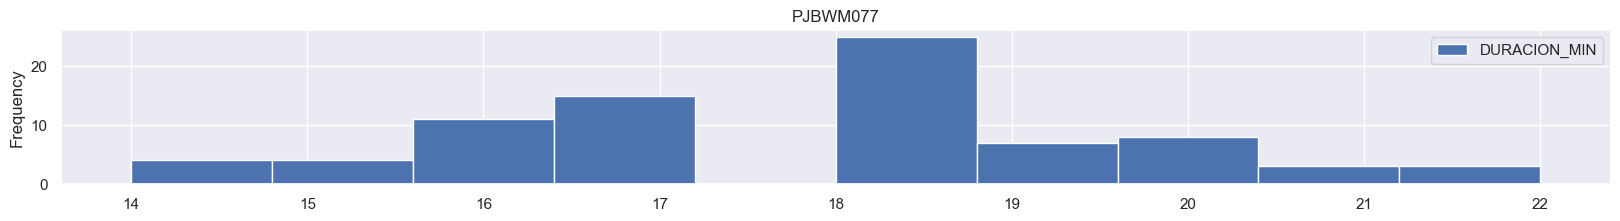

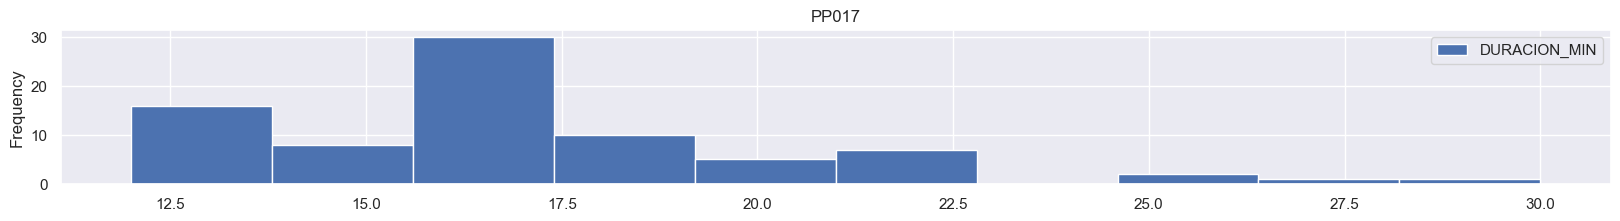

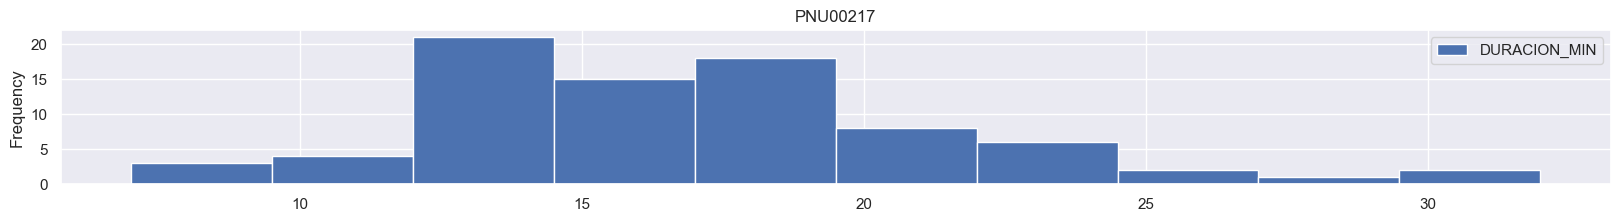

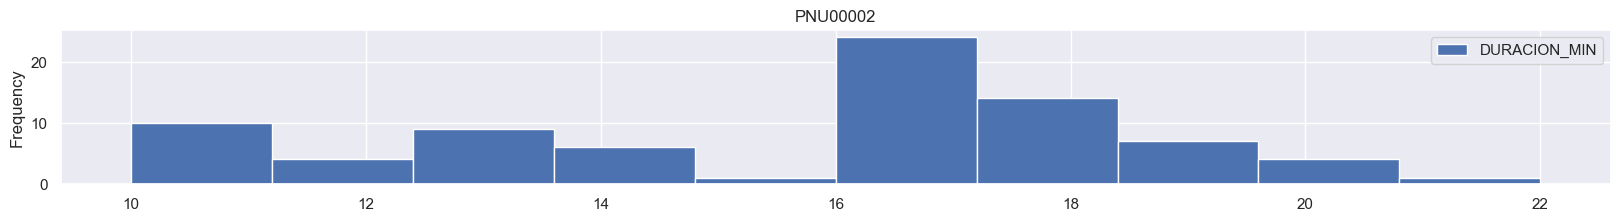

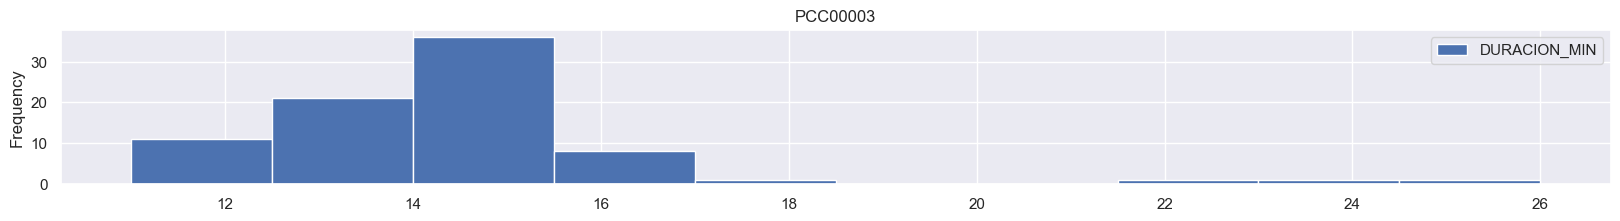

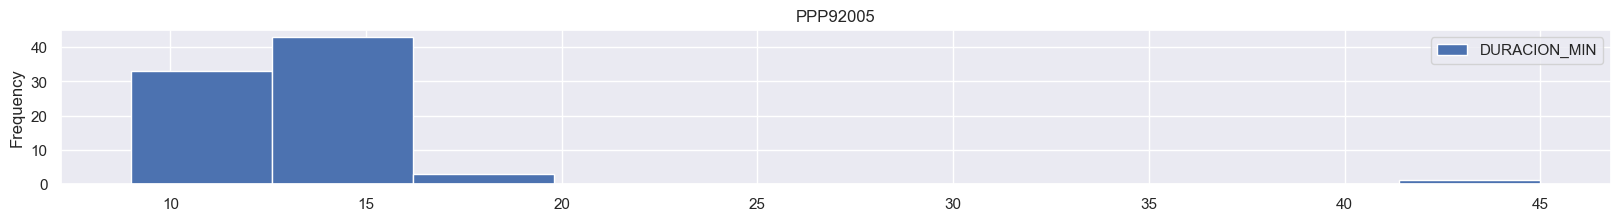

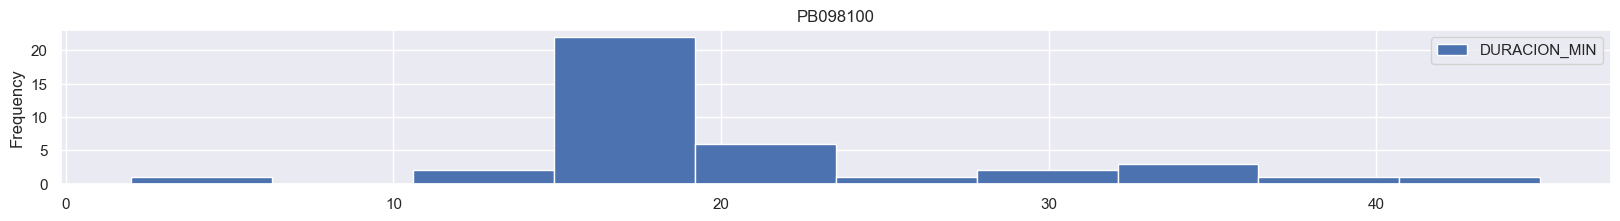

In [70]:
lst_top=df_agg_top.index.to_list()
sns.set_theme(rc={'figure.figsize':(20,2)})

for tarea in lst_top:
    df_parcial[df_parcial["CODIGO_TAREA"]==tarea][["CODIGO_TAREA","DURACION_MIN"]].plot.hist(bins=10,by="CODIGO_TAREA")
   

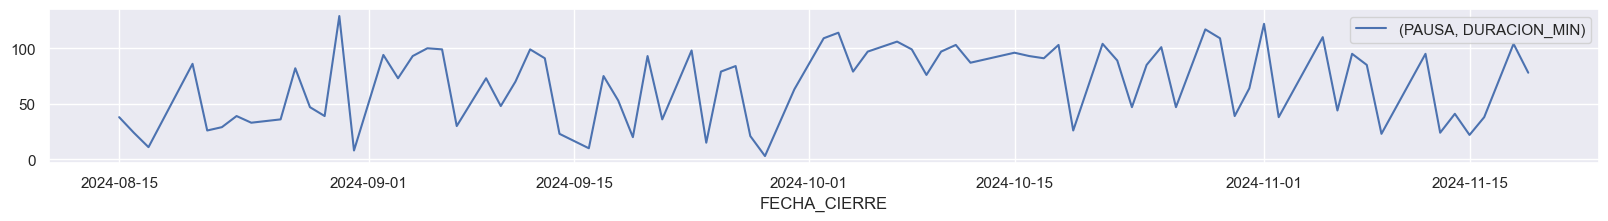

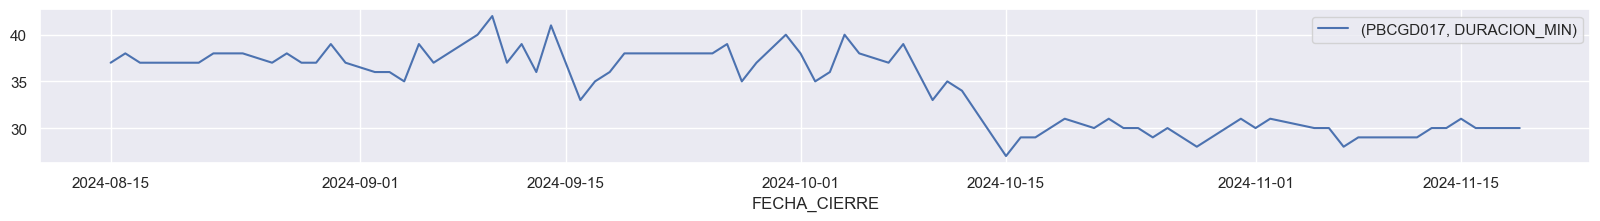

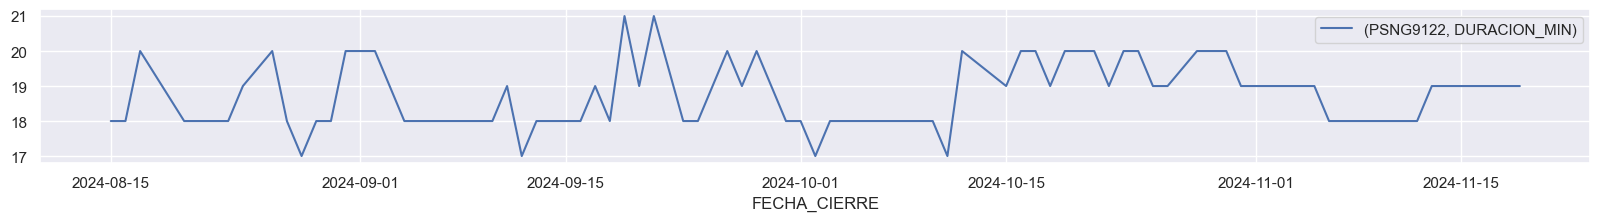

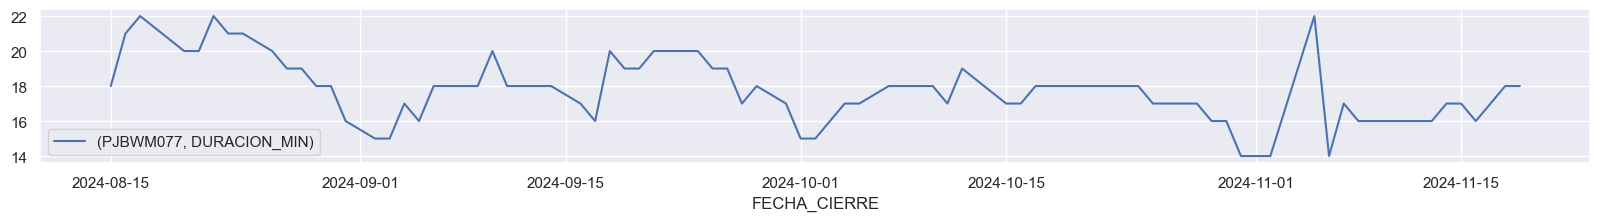

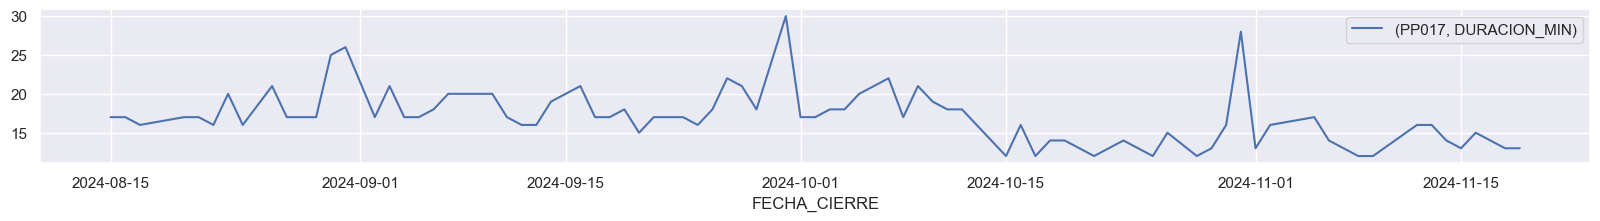

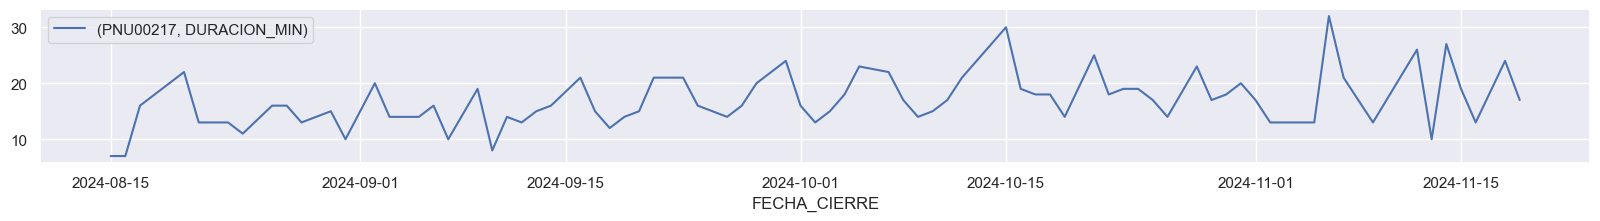

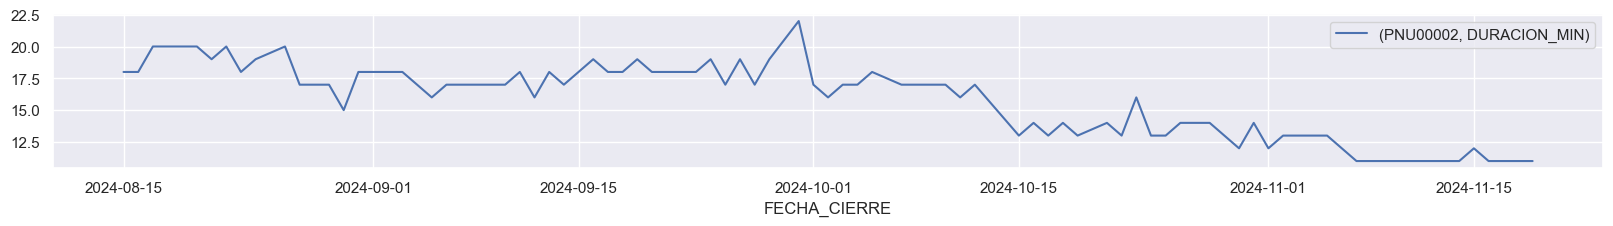

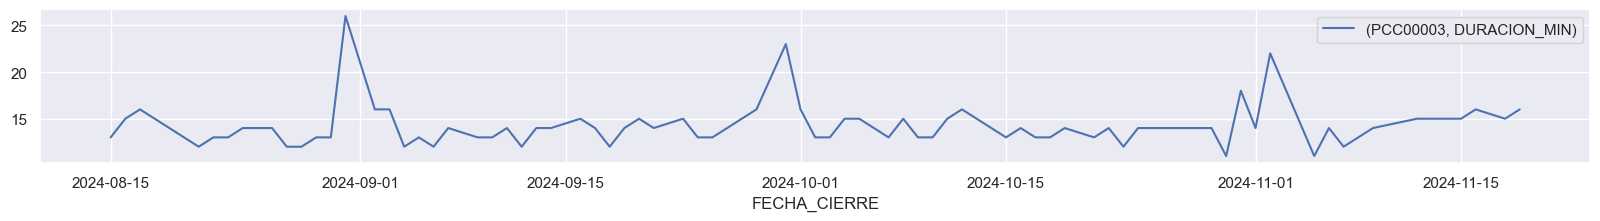

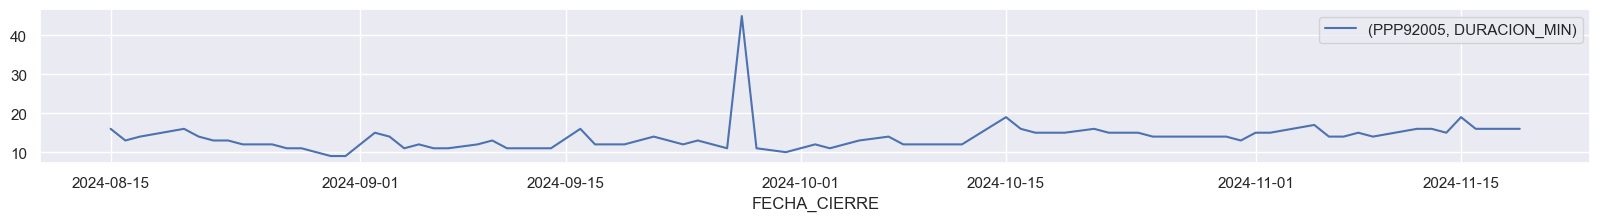

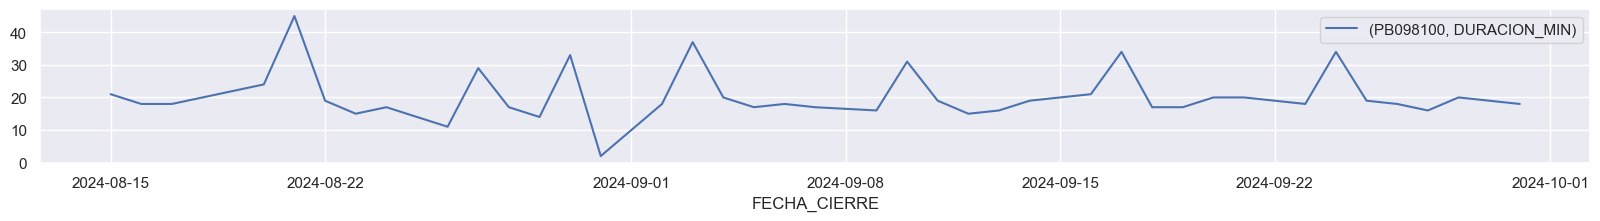

In [ ]:

for tarea in df_tareas_agg.sort_values("sum",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

### Ordenados por máximo

In [ ]:
df_tareas_agg.sort_values("max",ascending=False).head(15)

,max,min,mean,median,count,sum
CODIGO_TAREA,,,,,,
PAUSA,129.0,0.0,18.240000,4.0,400,7296.0
PAHP900,66.0,0.0,0.835443,0.0,79,66.0
PP020FV2,59.0,1.0,5.784810,1.0,79,457.0
PNU00009,46.0,4.0,6.126582,5.0,79,484.0
PPP92005,45.0,9.0,13.721519,13.0,79,1084.0
PB098100,45.0,2.0,20.461538,18.0,39,798.0
PBCGD017,42.0,27.0,34.506329,36.0,79,2726.0
PP020A,37.0,3.0,7.632911,6.0,79,603.0
PNU00117,33.0,1.0,2.544304,1.0,79,201.0


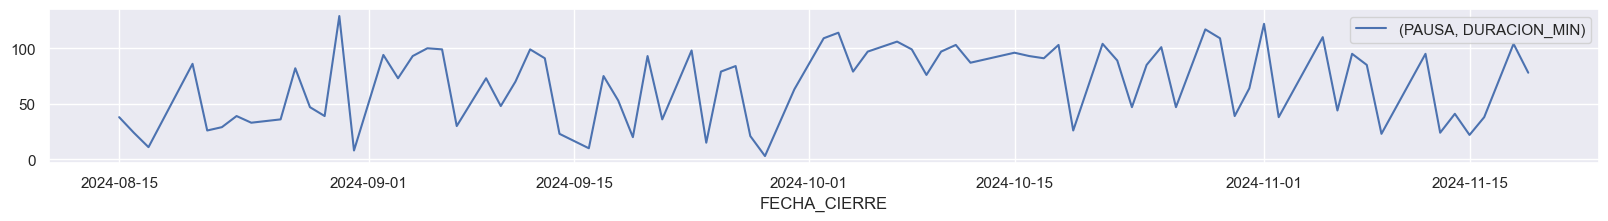

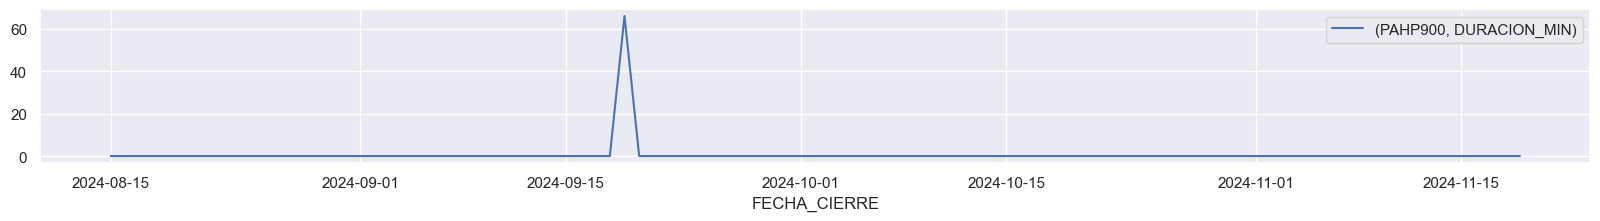

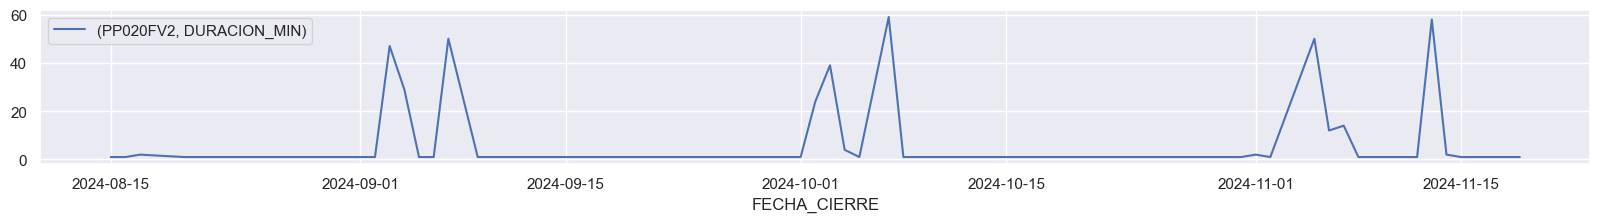

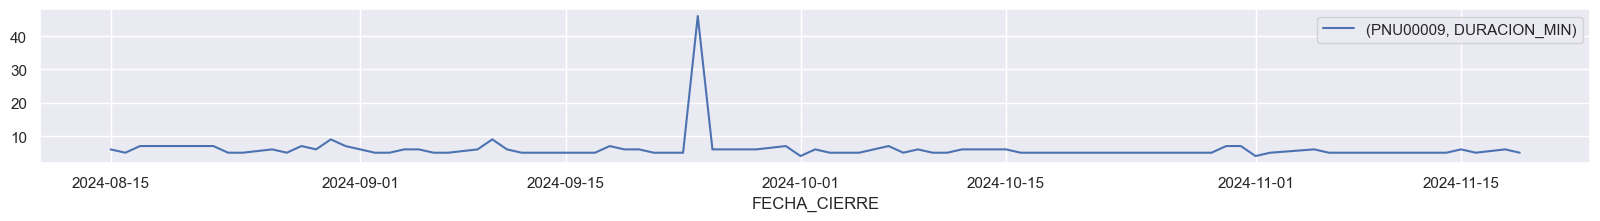

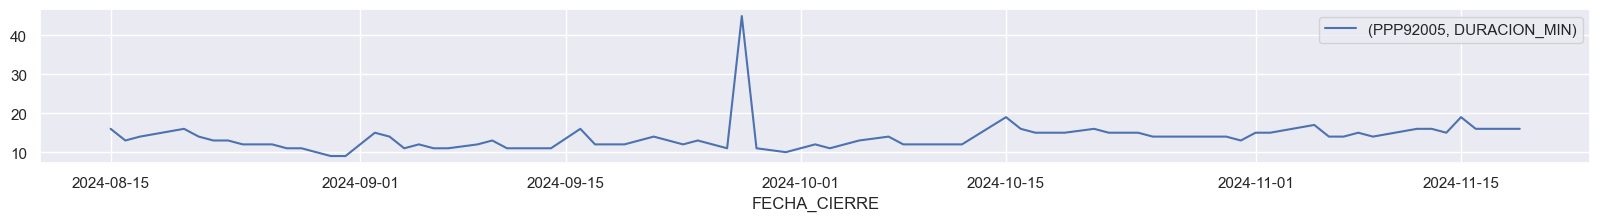

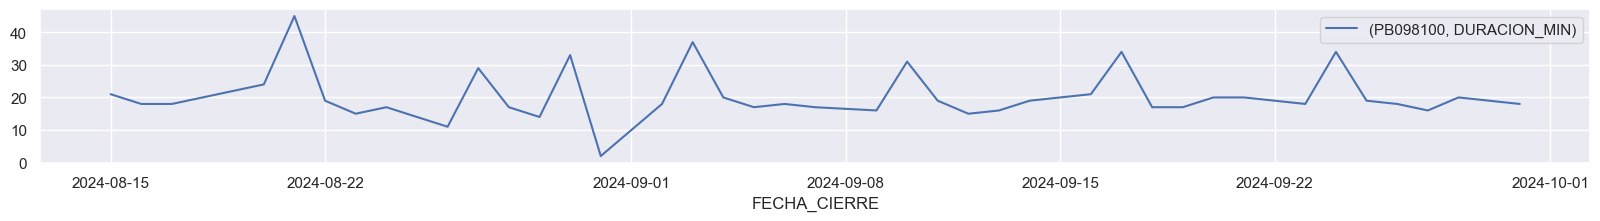

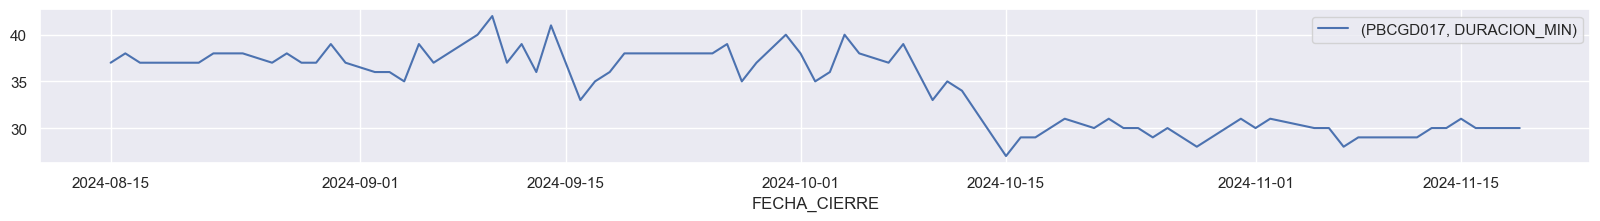

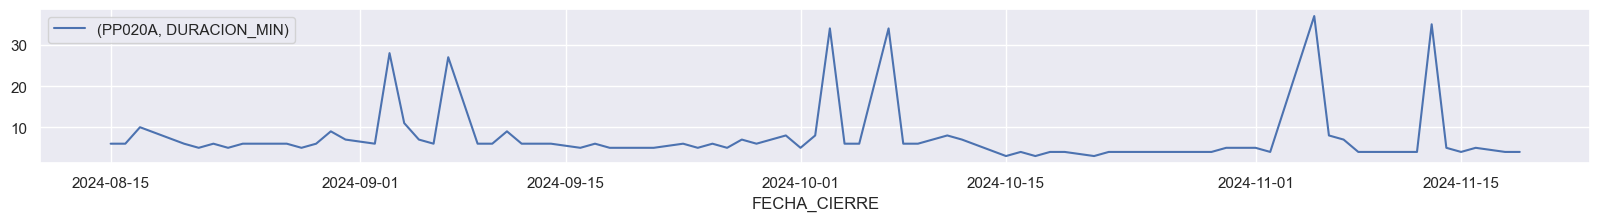

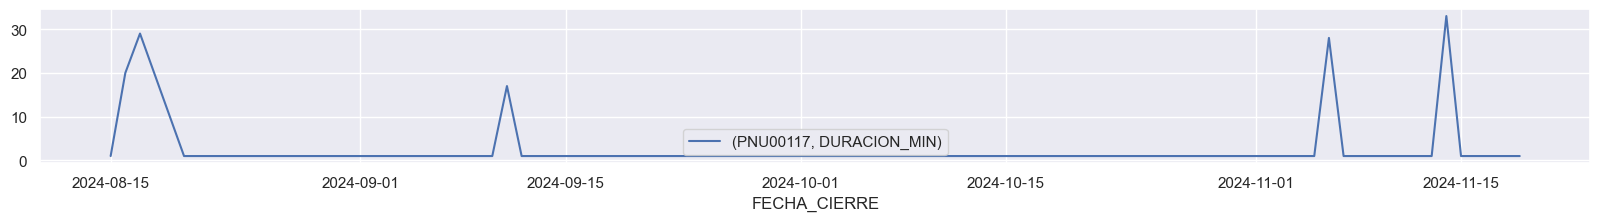

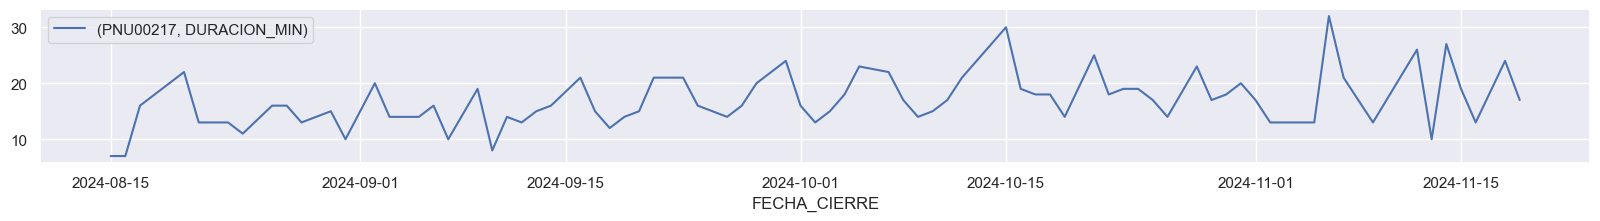

In [ ]:

for tarea in df_tareas_agg.sort_values("max",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

<Axes: >

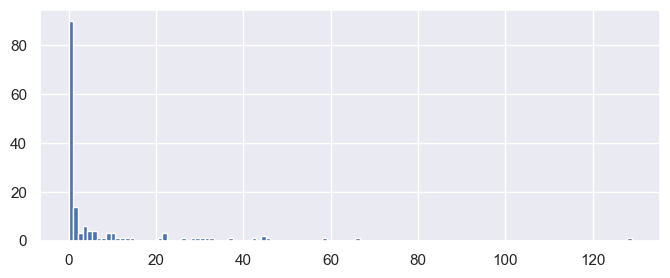

In [ ]:
df_tareas_agg["max"].hist(bins=120)


In [95]:
df_tareas_agg.groupby("max").size()


max
0.0      67
1.0      23
2.0      14
3.0       3
4.0       6
5.0       4
6.0       4
7.0       1
8.0       1
9.0       3
10.0      3
11.0      1
12.0      1
13.0      1
15.0      1
21.0      1
22.0      3
26.0      1
28.0      1
30.0      1
31.0      1
32.0      1
33.0      1
37.0      1
42.0      1
45.0      2
46.0      1
59.0      1
66.0      1
129.0     1
dtype: int64

## Correlacion

In [75]:
crosstab_df = pd.crosstab(df_parcial['FECHA_CIERRE'], df_parcial['CODIGO_TAREA'], values=df['DURACION_SEGUNDOS'], aggfunc='sum')
crosstab_df


CODIGO_TAREA,OCIE1000,PAHP900,PAR00280,PAUSA,PB098100,PB098105,PB098110,PB098540,PB098541,PBAEN30A,...,PSID0002,PSID0003,PSNG9122,PSNG917,PSNG917A,PX17066I,PX999C17,PX999W17,RFS00099,RFS00308
FECHA_CIERRE,,,,,,,,,,,,,,,,,,,,,
2024-08-15,1.0,11.0,18.0,3613.0,1262.0,19.0,134.0,2.0,3.0,102.0,...,2.0,1.0,1082.0,485.0,1.0,1.0,1.0,1.0,37.0,146.0
2024-08-16,1.0,10.0,17.0,2717.0,1071.0,19.0,62.0,2.0,2.0,108.0,...,1.0,1.0,1106.0,472.0,1.0,2.0,1.0,1.0,35.0,133.0
2024-08-17,2.0,11.0,24.0,1155.0,1107.0,19.0,50.0,2.0,3.0,102.0,...,3.0,2.0,1194.0,560.0,2.0,1.0,1.0,1.0,21.0,167.0
2024-08-20,2.0,11.0,17.0,5758.0,1460.0,20.0,97.0,2.0,3.0,95.0,...,2.0,1.0,1073.0,487.0,2.0,1.0,1.0,1.0,41.0,163.0
2024-08-21,1.0,10.0,17.0,2805.0,2675.0,18.0,56.0,3.0,3.0,99.0,...,1.0,1.0,1081.0,504.0,2.0,1.0,1.0,2.0,38.0,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-15,1.0,10.0,18.0,1681.0,NaN,19.0,166.0,2.0,2.0,70.0,...,1.0,1.0,1134.0,389.0,1.0,1.0,2.0,1.0,39.0,178.0
2024-11-16,2.0,10.0,19.0,5190.0,NaN,18.0,56.0,2.0,2.0,81.0,...,1.0,1.0,1155.0,384.0,1.0,1.0,1.0,2.0,135.0,200.0
2024-11-18,2.0,10.0,18.0,7282.0,NaN,19.0,71.0,2.0,3.0,69.0,...,2.0,1.0,1144.0,377.0,1.0,1.0,1.0,1.0,39.0,173.0


In [83]:
correlation_matrix = crosstab_df.corr()


<Axes: xlabel='CODIGO_TAREA', ylabel='CODIGO_TAREA'>

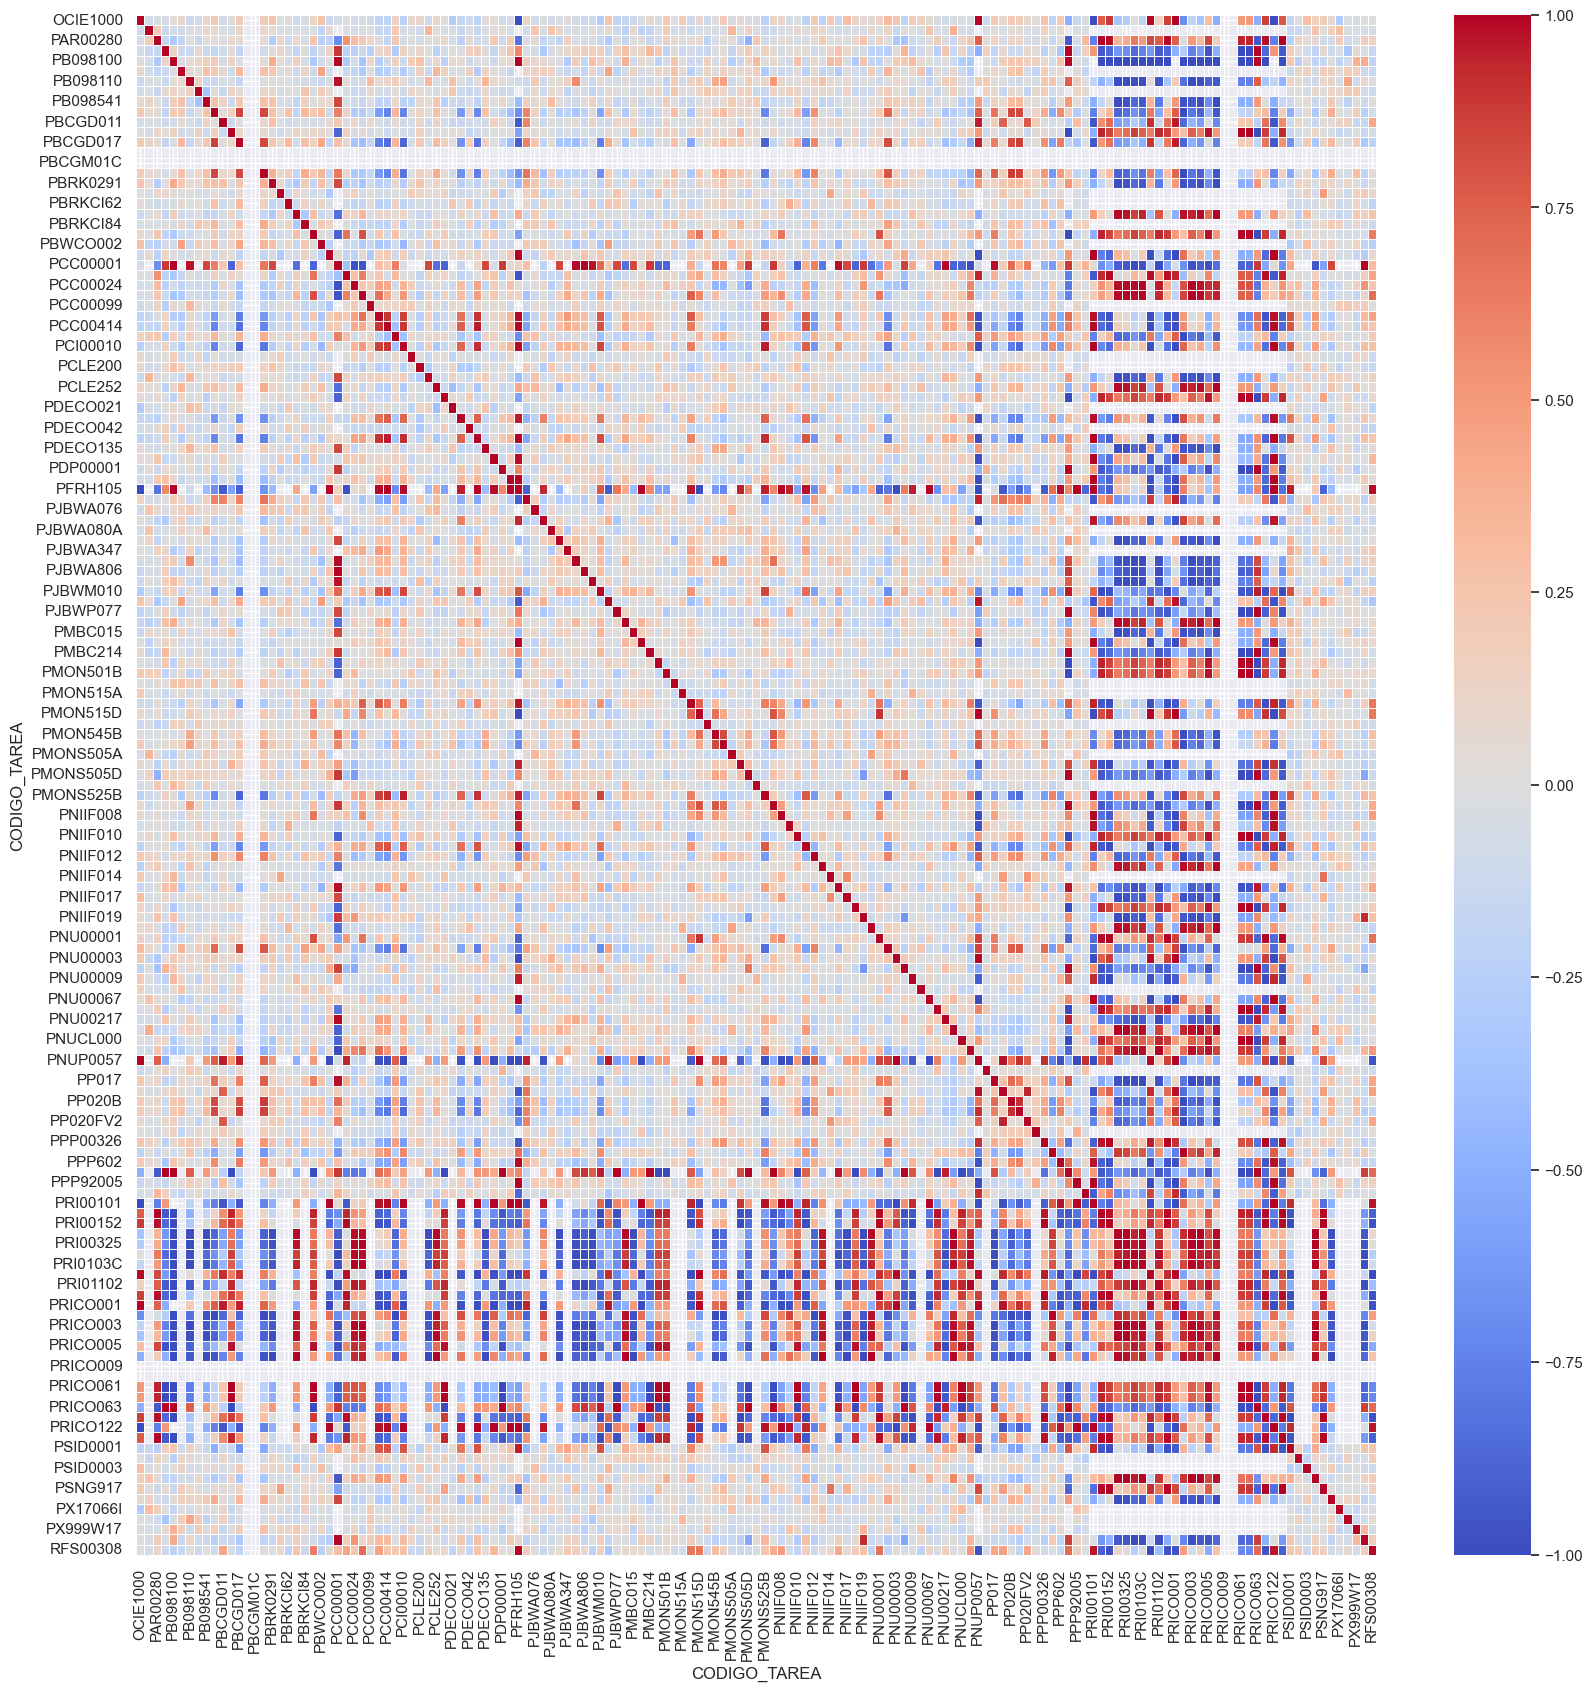

In [82]:

sns.set_theme(rc={'figure.figsize':(20,20)})

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)